In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
def simulate_gbm(S0, mu, sigma, T, N, n_paths, leverage):
    # simulate n_paths many paths from 0 to T of GBM with parameters mu and sigma
    dt = T / N
    times = np.linspace(0, T, N + 1)

    Z = np.random.randn(n_paths, N)

    drift = (mu - (1 / 2) * (sigma**2)) * dt
    diffusion = sigma * np.sqrt(dt) * Z

    logS = np.zeros((n_paths, N + 1))
    logS[:, 0] = np.log(S0)
    logS[:, 1:] = np.cumsum(drift + diffusion, axis=1) + logS[:, :1]

    # leveraged log-returns
    logL = np.zeros((n_paths, N + 1))
    logL[:, 0] = logS[:, 0]
    logL[:, 1:] = (
        np.cumsum(np.log((np.exp(drift + diffusion) - 1) * leverage + 1), axis=1)
        + logL[:, :1]
    )

    S_end = np.exp(logS[:, N])
    L_end = np.exp(logL[:, N])
    L_end[np.isnan(L_end)] = 0

    return L_end - S_end

In [12]:
diff = simulate_gbm(1, 0.01, 0.02, 100, 100, 1000, 2)

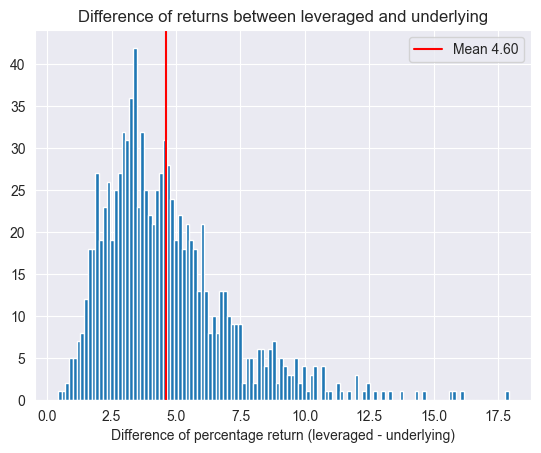

In [13]:
sns.set_style("darkgrid")

plt.figure()
plt.title(f"Difference of returns between leveraged and underlying")
plt.xlabel(f"Difference of percentage return (leveraged - underlying)")
mean = diff.mean()
plt.axvline(x=mean, label=f"Mean {mean:.2f}", color="red")
plt.hist(diff, bins=120)

plt.legend()
plt.show()

In [5]:
import itertools


# expirations = days to expiration
# update_times = time between updates in units of days (half-hour, day, minutes)
# factors = leverage factors
def plot_comparison(
    mus=[0],
    sigmas=[0.02],
    expirations=[5],
    daily_frequencies=[13],
    factors=[2],
    n_paths=1000,
):
    plt.figure()

    for mu, sigma, T, freq, factor in itertools.product(
        mus, sigmas, expirations, daily_frequencies, factors
    ):
        difference = simulate_gbm(1, mu, sigma, T, T * freq, n_paths, factor)
        plt.hist(
            difference,
            bins=100,
            alpha=0.5,
            label=f"duration = {T} \nfactor = {factor} \nfrequency = {freq} \nmedian = {np.median(difference):.2f} \nmean = {difference.mean():.2f} \nstd = {difference.std():.2f}",
        )

    plt.xlabel(f"Difference of lETF - asset percentage returns")
    plt.legend()
    plt.show()

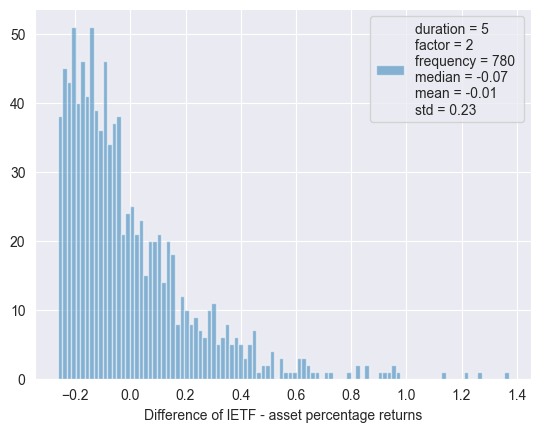

In [6]:
expirations = [5, 10, 21, 100, 200]
daily_frequencies = [780, 13, 1]
factors = [2, 3, 5]

plot_comparison(sigmas=[0.1], daily_frequencies=[780])

In [7]:
def plot_whisk_frequency(
    mu=0,
    sigma=0.01,
    T=5,
    n_paths=1000,
    frequencies=[1, 2, 13, 780, 10000, 46800],
    leverage=2,
):
    box_data = []
    for freq in frequencies:
        diff = simulate_gbm(1, mu, sigma, T, T * freq, n_paths, leverage)
        mean = diff.mean()
        std = diff.std()
        box_data.append(
            {
                "med": mean,
                "q1": mean - 0.5 * std,
                "q3": mean + 0.5 * std,
                "whislo": min(diff),
                "whishi": max(diff),
                "fliers": [],
            }
        )

    # Create boxplot
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.bxp(box_data, showfliers=False)

    # Label x-axis with mu values
    ax.set_xticks(np.arange(1, len(frequencies) + 1))
    ax.set_xticklabels([f"{freq:.2f}" for freq in frequencies])

    ax.set_xlabel("Update frequency")
    ax.set_ylabel("Profit")
    ax.set_title(
        f"Profit distribution of a {leverage}x leveraged ETF vs update frequency"
    )

    # Add annotations for each box
    for i in range(len(frequencies)):
        text = f"avg = ${box_data[i]["med"]:.2f}\nσ = ${2*(box_data[i]["q3"] - box_data[i]["med"]):.2f}\nmin = ${box_data[i]["whislo"]:.2f}\nmax = ${box_data[i]["whishi"]:.2f}"
        ax.text(
            i + 1,  # x-position (box number)
            -0.04,  # y just above whisker
            text,
            ha="center",
            va="bottom",
            fontsize=9,
            bbox=dict(
                facecolor="white", alpha=0.6, edgecolor="gray", boxstyle="round,pad=0.2"
            ),
        )

    plt.axhline(y=0, color="r", linestyle="--", linewidth=0.2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

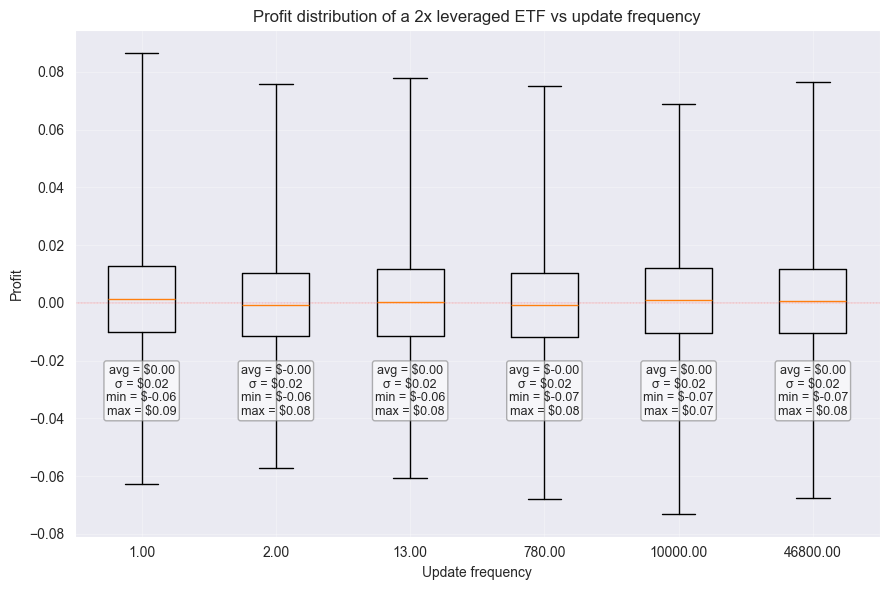

In [8]:
plot_whisk_frequency()

/var/folders/zh/4snkqr657fb06hs2r74_4xpm0000gn/T/ipykernel_67376/3550802865.py:24: RuntimeWarning: overflow encountered in exp
  L_end = np.exp(logL[:, N])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/_methods.py:188: RuntimeWarning: invalid value encountered in subtract
  x = um.subtract(arr, arrmean, out=...)
/var/folders/zh/4snkqr657fb06hs2r74_4xpm0000gn/T/ipykernel_67376/3550802865.py:23: RuntimeWarning: overflow encountered in exp
  S_end = np.exp(logS[:, N])
/var/folders/zh/4snkqr657fb06hs2r74_4xpm0000gn/T/ipykernel_67376/3550802865.py:27: RuntimeWarning: invalid value encountered in subtract
  return L_end - S_end


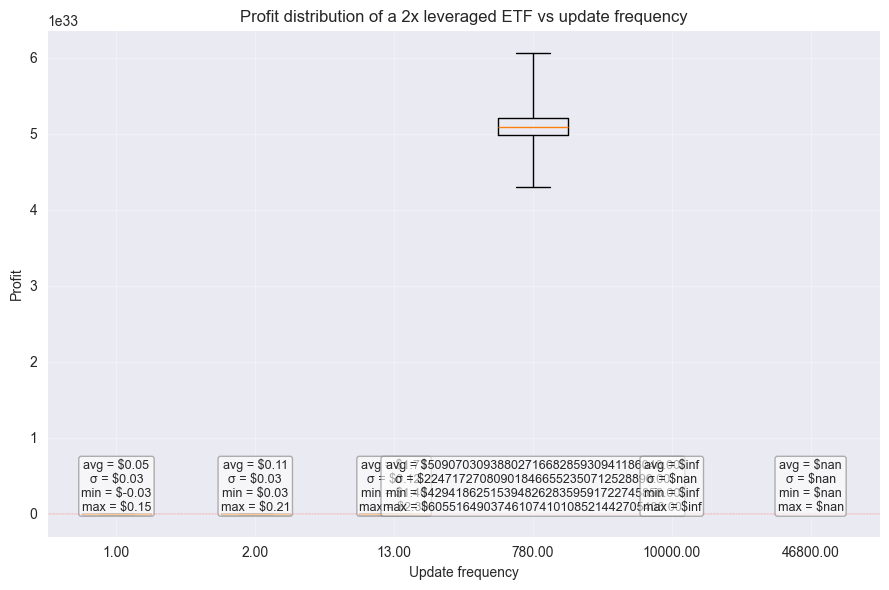

In [9]:
plot_whisk_frequency(mu=0.01)

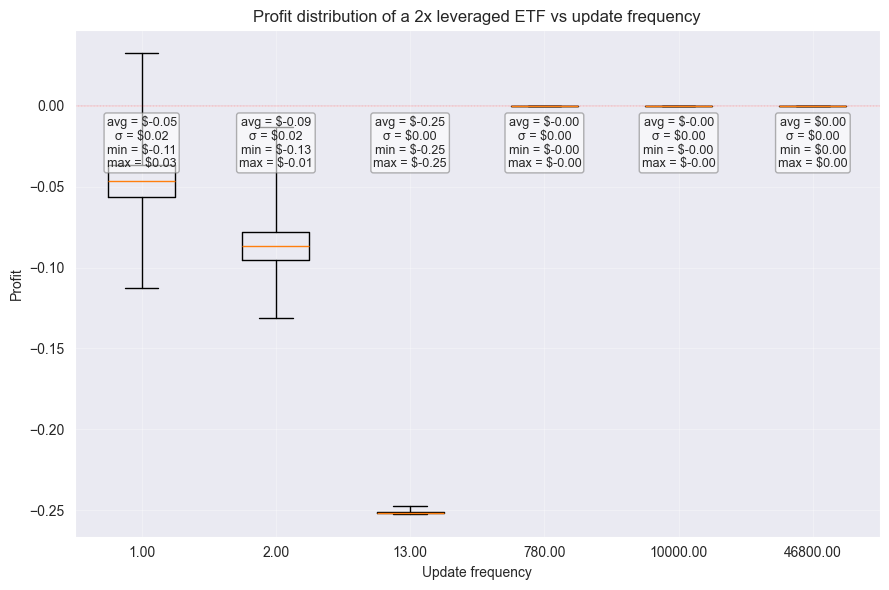

In [10]:
plot_whisk_frequency(mu=-0.01)

Conclusion: PnL seems highly unstable with respect to frequency as soon as drift is added, even though the theoretical limit is $L = S^2$ as the frequency goes to $\infty$.